# Getting Started - RocketPy in Coab

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'RocketPy' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [ ]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [ ]:
Env = Environment(
    railLength=2.4384, latitude=35.176307, longitude=-76.826296, elevation=10
)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [ ]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((2022, 11, 19, 18))  # Hour given in UTC time


Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [ ]:
Env.setAtmosphericModel(type="StandardAtmosphere")

We can see what the weather will look like by calling the info method!

Launch Site Details

Launch Rail Length: 2.4384  m
Launch Date: 2022-11-19 18:00:00 UTC
Launch Site Latitude: 35.17631°
Launch Site Longitude: -76.82630°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 333696.17 W    3894122.34 N
Launch Site UTM zone: 17S
Launch Site Surface Elevation: 10.0 m


Atmospheric Model Details

Atmospheric Model Type: StandardAtmosphere
StandardAtmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1012.05 hPa
Surface Temperature: 288.08 K
Surface Air Density: 1.224 kg/m³
Surface Speed of Sound: 340.25 m/s


Atmospheric Model Plots


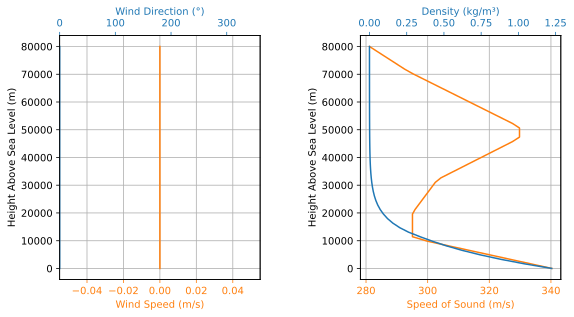

In [ ]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [ ]:

J420R = SolidMotor(
    thrustSource="/content/drive/Shareddrives/HPRC 2022-23 NASA SL/Senior Design/CDR/Rocket Py/AeroTech_J420R.eng",
    burnOut=1.6,
    grainNumber=6,
    grainSeparation= 0,
    grainDensity= 1730,
    grainOuterRadius= 0.031661,
    grainInitialInnerRadius= 0.0166116,
    grainInitialHeight= 0.047625,
    nozzleRadius= 0.015875,
    throatRadius= 0.0071374,
    interpolationMethod="linear",
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!


Motor Details
Total Burning Time: 1.64 s
Total Propellant Mass: 1.128 kg
Propellant Exhaust Velocity: 577.201 m/s
Average Thrust: 397.087 N
Maximum Thrust: 563.47 N at 0.095 s after ignition.
Total Impulse: 651.222 Ns

Plots


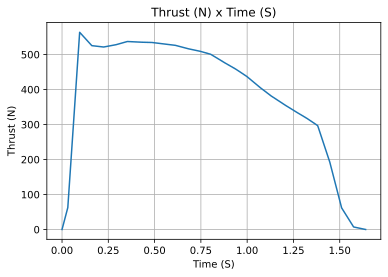

In [ ]:
J420R.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Calisto, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [ ]:
SubScale = Rocket(
    motor=J420R,
    radius= 0.07835,
    mass= 4.6266,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-0.7,
    distanceRocketPropellant=-0.577125,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv", #Help figuring out how to remake these
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

SubScale.setRailButtons([0.2, -0.5]) #Ben Help what does this mean? And how do I simulate it

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

In [ ]:
NoseCone = SubScale.addNose(length=0.508, kind="ogive", distanceToCM=0.71971)

FinSet = SubScale.addTrapezoidalFins(
    n=4,
    rootChord=0.152,
    tipChord=0.084,
    span=0.102,
    distanceToCM=-0.51,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = SubScale.addTail(
    topRadius=0.051, bottomRadius=0.019, length=0.124, distanceToCM=-1.194656
)

#### Adding Parachutes

Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also receives the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [ ]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 167.64 + Env.elevation else False


Main = SubScale.addParachute(
    "Main",
    CdS=10.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = SubScale.addParachute(
    "Drogue",
    CdS=1.0,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```

## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.

In [ ]:
TestFlight = Flight(rocket=SubScale, environment=Env, inclination=90, heading=0)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 10.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 1.000 | e1: 0.000 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : 180.00° | Nutation θ: -0.00° | Precession ψ: -180.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 90.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 0.251 s
Rail Departure Velocity: 15.985 m/s
Rail Departure Static Margin: -1.173 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 9.581
Rail Departure Reynolds Number: 1.713e+05


BurnOut State

BurnOut time: 1.640 s
Altitude at burnOut: 99.770 m (AGL)
Rocket velocity at burnOut: 102.439 m/s
Freestream velocity at burnOut: 102.439 m/s
Mach Number at burnOut: 0.301
Kinetic energy at burnOut: 2.428e+04 J


Apogee

A

/usr/local/lib/python3.8/dist-packages/rocketpy/Flight.py:2577: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax1.set_ylim3d([minXY, maxXY])
/usr/local/lib/python3.8/dist-packages/rocketpy/Flight.py:2578: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax1.set_xlim3d([minXY, maxXY])


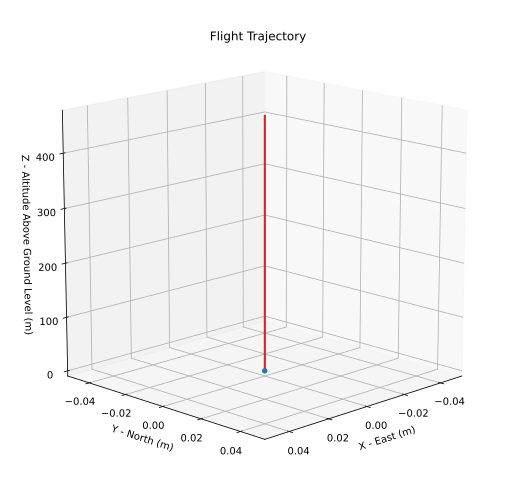



Trajectory Kinematic Plots



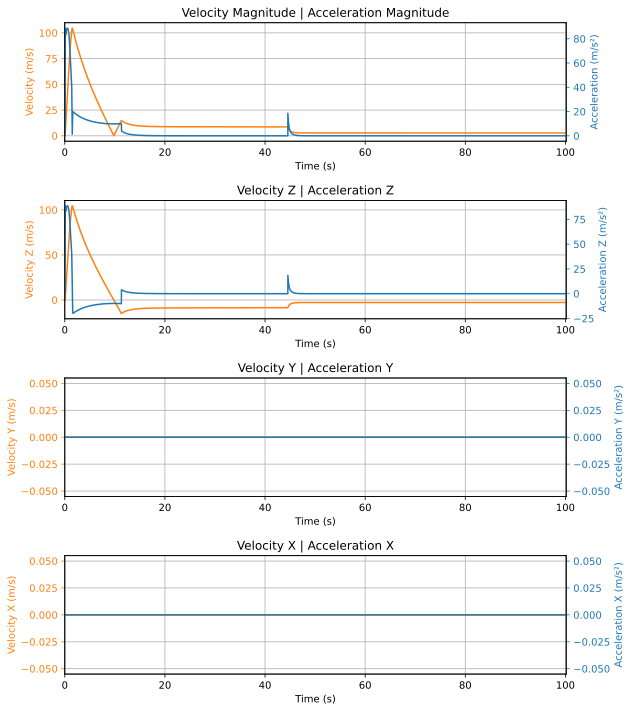



Angular Position Plots



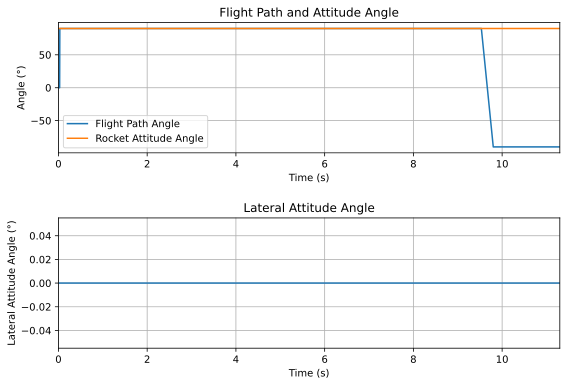



Path, Attitude and Lateral Attitude Angle plots



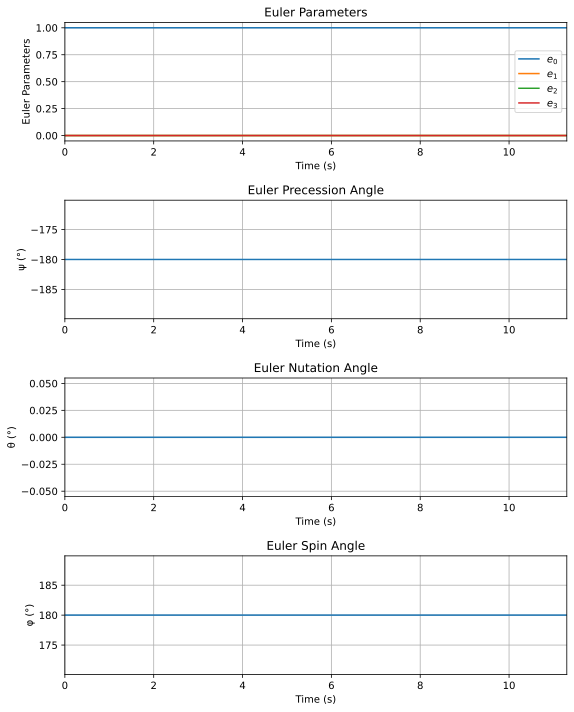



Trajectory Angular Velocity and Acceleration Plots



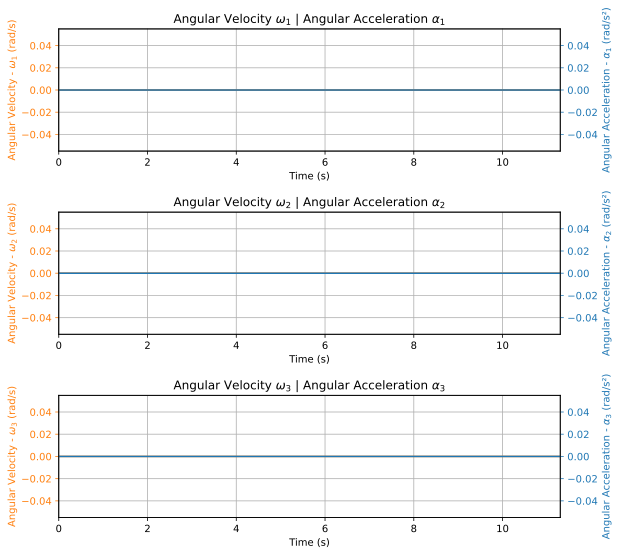



Trajectory Force Plots



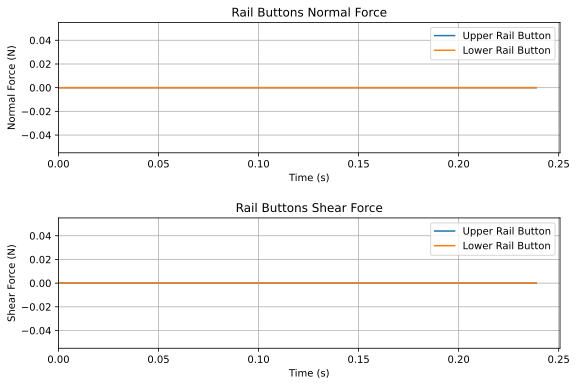

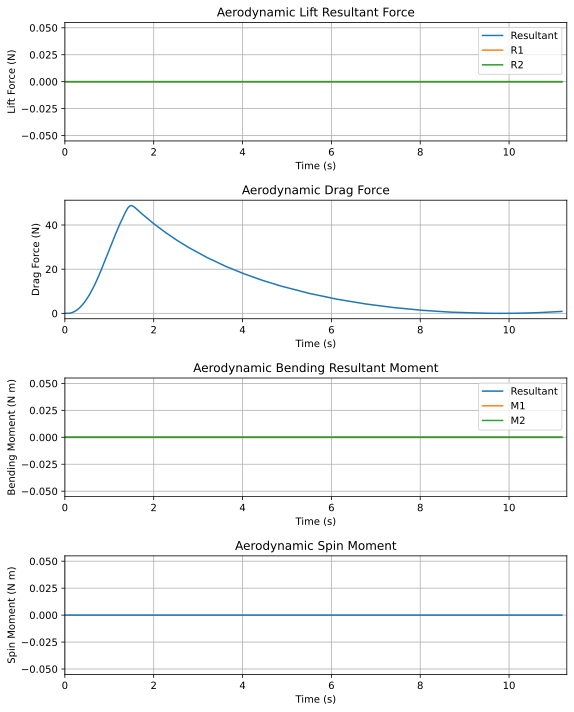



Trajectory Energy Plots



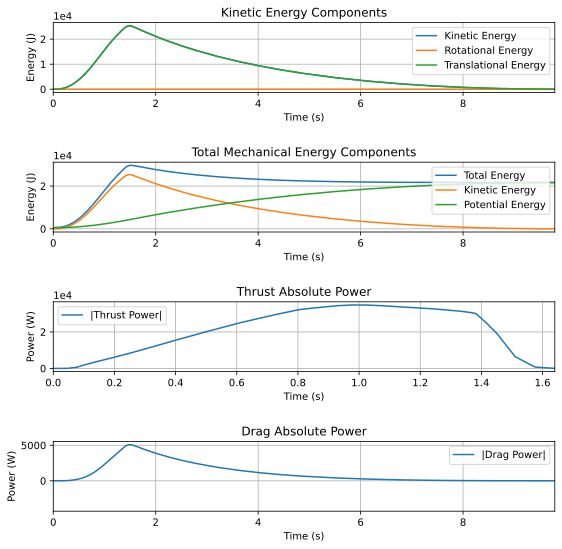



Trajectory Fluid Mechanics Plots



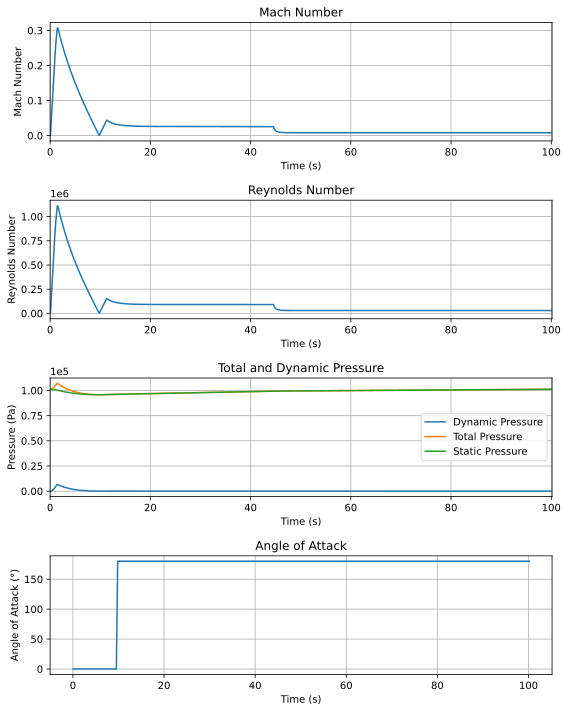



Trajectory Stability and Control Plots



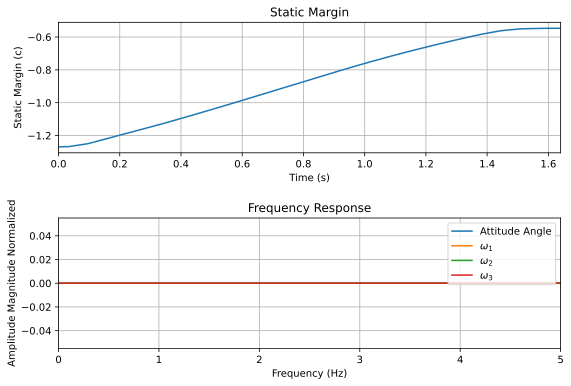

In [ ]:
TestFlight.allInfo()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [ ]:
TestFlight.exportKML(
    fileName="trajectory.kml",
    extrude=True,
    altitudeMode="relativetoground",
)

from google.colab import files
files.download('trajectory.kml')

File  trajectory.kml  saved with success!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.

In [ ]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
FullScale_Fin = Rocket(
    motor=J420R,
    radius=156.7 / 2000,
    mass= 19.5,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv", #Help figuring out how to remake these
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)
FullScale_Fin.setRailButtons([0.2, -0.5])
Nose = FullScale_Fin.addNose(length=0.55829, kind="ogive", distanceToCM=0.71971)
FinSet = FullScale_Fin.addTrapezoidalFins(
    4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = FullScale_Fin.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.setAtmosphericModel(type="CustomAtmosphere", wind_v= 5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]:
    # Modify rocket fin set by removing previous one and adding new one
    FullScale_Fin.aerodynamicSurfaces.remove(FinSet)
    FinSet = FullScale_Fin.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor
  )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            FullScale_Fin.staticMargin(0), FullScale_Fin.staticMargin(FullScale_Fin.motor.burnOutTime)
        )
    )
    TestFlight = Flight(
        rocket=FullScale_Fin,
        environment=Env,
        inclination=8,
        heading=0,
        maxTimeStep=0.1,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = FullScale_Fin.staticMargin(0)
    staticMarginAtOutOfRail = FullScale_Fin.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = FullScale_Fin.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]
print(simulation_results)
Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

NameError: ignored

In [ ]:
print(simulation_results)

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Env = Environment(
#    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
#)

Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

# Prepare Motor
#Pro75M1670 = SolidMotor(
#    thrustSource="../../data/motors/Cesaroni_M1670.eng",
#    burnOut=3.9,
#    grainNumber=5,
#    grainSeparation=5 / 1000,
#    grainDensity=1815,
#    grainOuterRadius=33 / 1000,
#    grainInitialInnerRadius=15 / 1000,
#    grainInitialHeight=120 / 1000,
#    nozzleRadius=33 / 1000,
#    throatRadius=11 / 1000,
#    interpolationMethod="linear",
#)

# Prepare Rocket
#Calisto = Rocket(
#    motor=Pro75M1670,
#    radius=127 / 2000,
#    mass=19.197 - 2.956,
#    inertiaI=6.60,
#    inertiaZ=0.0351,
#    distanceRocketNozzle=-1.255,
#    distanceRocketPropellant=-0.85704,
#    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
#    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
#)

#Calisto.setRailButtons([0.2, -0.5])

#Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
#FinSet = Calisto.addTrapezoidalFins(
#    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
#)
#Tail = Calisto.addTail(
#    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
#)

simulation_results_rails = []

for factor2 in [ .1, .5, 1, 1.5, 2]:

    # Modify rocket rail by removing previous one and adding new one
    button1 = factor2*.2
    button2 = factor2*-0.5 - factor2*.1
    FullScale.setRailButtons([button1, button2])
    print(FullScale.railButtons.distanceToCM)
    
    # Simulate first 5 seconds of Flight
    TestFlight = Flight(
        rocket=FullScale,
        environment=Env,
        inclination=85,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
)
    TestFlight.postProcess()

    # Perform a Fourier Analysis
    Fs = 100.0
    # sampling rate
    Ts = 1.0 / Fs
    # sampling interval
    t = np.arange(1, 400, Ts)  # time vector
    ff = 5
    # frequency of the signal
    y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    frq = frq[range(n // 2)]  # one side frequency range
    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y = abs(Y[range(n // 2)])

    simulation_results_rails += [t,y,frq,Y]

print(simulation_results_rails)


In [ ]:

fig, ax = plt.subplots(2, 1)
ax[0].plot(simulation_results_rails[0], simulation_results_rails[1],"r", simulation_results_rails[12], simulation_results_rails[13],"g")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[1].plot(simulation_results_rails[2], simulation_results_rails[3],"r", simulation_results_rails[14], simulation_results_rails[15],"g")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.

In [ ]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
        powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
    )

    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Calisto.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.apogee


apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8, 20, 20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

In [ ]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
        powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
    )

    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Calisto.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.outOfRailVelocity


speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8, 20, 20)